In [13]:
import os
from jf import Mymaps
import matplotlib.pyplot as plt 
import numpy as np 
from astropy.wcs import WCS
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
import reproject as rp
from scipy import stats
from tqdm import trange
from astropy.coordinates import SkyCoord
from astropy.nddata.utils import Cutout2D
import astropy.units as u

with fits.open('./data2/galaxies_sorted.fits') as hdulist:
    plateifu_list = hdulist[1].data['plateifu']
    RAs = hdulist[1].data['RA']
    DECs = hdulist[1].data['DEC']
    
lofar_file_path = './data2/lofar_imgs/'
lofar_list = os.listdir(lofar_file_path)
lofar_list = np.sort(lofar_list)

import warnings 
warnings.filterwarnings("ignore")

In [5]:
def ptp_plot(n):
    gal = Mymaps(plateifu=plateifu_list[n], max_radii=10)
    with fits.open(lofar_file_path+lofar_list[n]) as hdulofar:
        lofarim = hdulofar[0].data
        lofar_header = hdulofar[0].header
    ha = gal.psf_m()
    lofarim_up, footprint = rp.reproject_exact((lofarim, WCS(lofar_header)), gal.wcs, shape_out=np.shape(ha))
    mean, med, sd = sigma_clipped_stats(lofarim)
    ha[lofarim_up<mean+3*sd] = np.nan
    lofarim_up[np.isnan(ha)] = np.nan
    fig = plt.figure()
    ax1 = plt.subplot(1,2,1,projection=gal.wcs)
    ax1.imshow(ha,origin='lower')
    ax1.contour(lofarim_up, colors='grey', levels=[mean+3*sd,mean+6*sd])
    ax2 = plt.subplot(1,2,2,projection=gal.wcs)
    ax2.imshow(lofarim_up,origin='lower')
    plt.show()
    c = stats.spearmanr(lofarim_up[~np.isnan(lofarim_up)],ha[~np.isnan(ha)])[0]
    fig = plt.figure()
    ax = plt.axes()
    ax.scatter(lofarim_up[~np.isnan(lofarim_up)],ha[~np.isnan(ha)])
    print(c)

def ptp(n):
    gal = Mymaps(plateifu=plateifu_list[n], max_radii=10)
    with fits.open(lofar_file_path+lofar_list[n]) as hdulofar:
        lofarim = hdulofar[0].data
        lofar_header = hdulofar[0].header
    ha = gal.psf_m()
    lofarim_up, footprint = rp.reproject_exact((lofarim, WCS(lofar_header)), gal.wcs, shape_out=np.shape(ha))
    mean, med, sd = sigma_clipped_stats(lofarim)
    ha[lofarim_up<mean+3*sd] = np.nan
    lofarim_up[np.isnan(ha)] = np.nan
    r = stats.spearmanr(lofarim_up[~np.isnan(lofarim_up)],ha[~np.isnan(ha)])[0]
    points = [lofarim_up[~np.isnan(lofarim_up)],ha[~np.isnan(ha)]]
    return r, points

def ptp_down(n):
    gal = Mymaps(plateifu=plateifu_list[n], max_radii=10)
    with fits.open(lofar_file_path+lofar_list[n]) as hdulofar:
        lofarim = hdulofar[0].data
        lofar_header = hdulofar[0].header
    ha = gal.psf_m()
    ha_down, footprint = rp.reproject_exact((ha, gal.wcs), lofar_header)
    mean, med, sd = sigma_clipped_stats(lofarim)
    ha_down[lofarim<mean+3*sd] = np.nan
    lofarim[np.isnan(ha_down)] = np.nan
    r = stats.spearmanr(lofarim[~np.isnan(lofarim)],ha_down[~np.isnan(ha_down)])[0]
    points = [lofarim[~np.isnan(lofarim)],ha_down[~np.isnan(ha_down)]]
    return r, points

100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


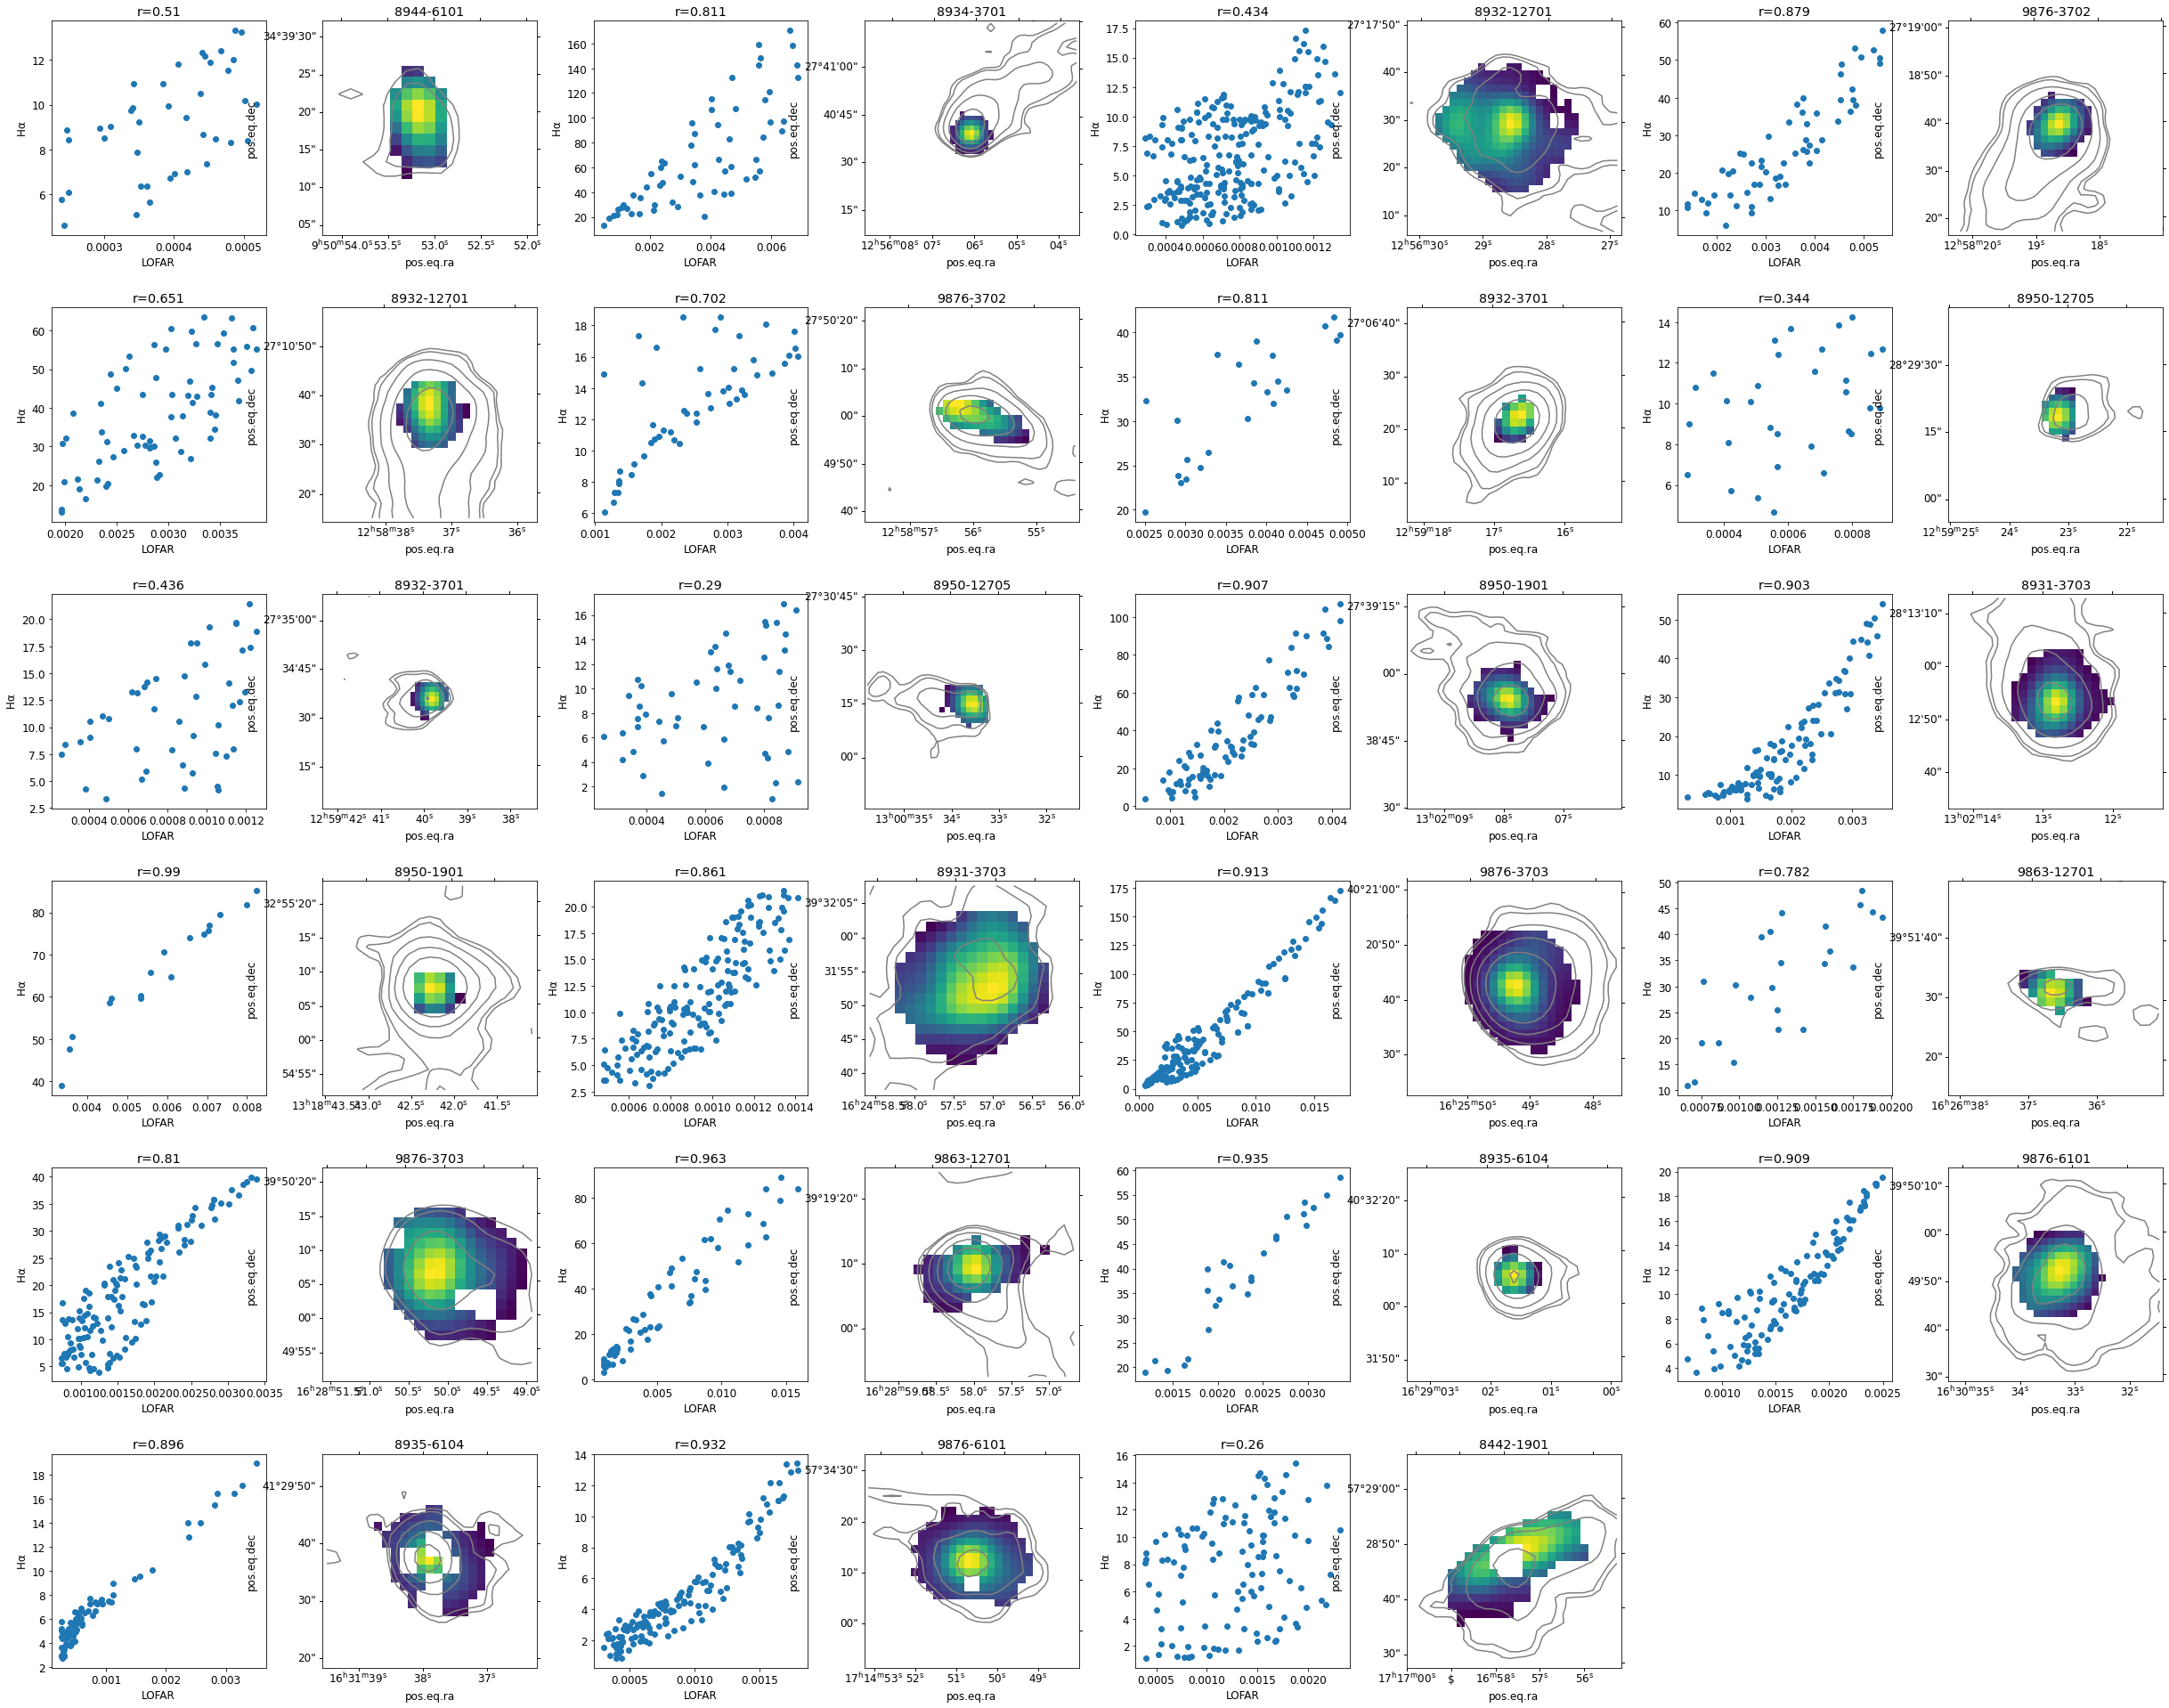

In [17]:
# fig, axs = plt.subplots(nrows=6, ncols=8, figsize=(34, 27))
row = 6
col = 4
plt.yticks(rotation=90)
for i in trange(row):
    for j in range(col):
        n = i*col+j
        if n<len(plateifu_list):
            gal = Mymaps(plateifu=plateifu_list[n], max_radii=10)
            with fits.open(lofar_file_path+lofar_list[n]) as hdulofar:
                lofarim = hdulofar[0].data
                lofar_header = hdulofar[0].header
            ha = gal.psf_m()
            ha_down, footprint = rp.reproject_exact((ha, gal.wcs), lofar_header)
            mean, med, sd = sigma_clipped_stats(lofarim)
            ha_down[lofarim<mean+3*sd] = np.nan
            lofar_im_copy = np.copy(lofarim)
            lofarim[np.isnan(ha_down)] = np.nan
            r = stats.spearmanr(lofarim[~np.isnan(lofarim)],ha_down[~np.isnan(ha_down)])[0]

            ax1 = plt.subplot(row, col*2, 2*n+1)
            ax1.scatter(lofarim[~np.isnan(lofarim)],ha_down[~np.isnan(ha_down)])
            ax1.set_xlabel('LOFAR')
            ax1.set_ylabel(r'$\mathrm{H\alpha}$')
            ax1.set_title('r='+str(round(r, 3) ))
            ax1.set_aspect(1.0/ax1.get_data_ratio(), adjustable='box')

            ra = RAs[n]
            dec = DECs[n]
            w_lofar = WCS(lofar_header)
            coord = SkyCoord(ra, dec, unit='deg', frame='icrs')
            cut_lofar = Cutout2D(lofar_im_copy, coord, 15/gal.ang_dis, wcs=w_lofar, mode='partial', fill_value=0)
            cut_ha = Cutout2D(ha_down, coord, 15/gal.ang_dis, wcs=w_lofar, mode='partial', fill_value=0)

            ax2 = plt.subplot(row, col*2, 2*n+2, projection=cut_lofar.wcs)
            ax2.imshow(cut_ha.data, origin='lower')
            ax2.contour(cut_lofar.data, colors='grey', levels = [mean+3*sd,mean+4*sd,mean+8*sd,mean+16*sd,mean+32*sd])
            


            # ax2.imshow(ha_down, origin='lower')
            # ax2.contour(lofarim, colors='grey')
            ax2.set_title(plateifu_list[i*(col//2)+j])

fig = plt.gcf()
fig.set_size_inches(34, 27)
plt.tight_layout()
fig.savefig('ptp_jelly.pdf')

(array([1., 2., 1., 0., 1., 2., 0., 5., 4., 7.]),
 array([0.26596015, 0.33689308, 0.407826  , 0.47875893, 0.54969185,
        0.62062478, 0.6915577 , 0.76249063, 0.83342355, 0.90435648,
        0.9752894 ]),
 <BarContainer object of 10 artists>)

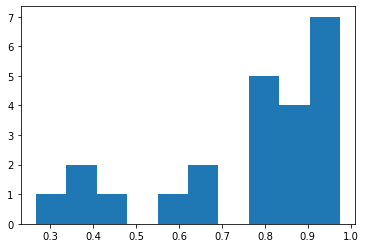

In [4]:
plt.hist(pcc)

100%|██████████| 23/23 [00:04<00:00,  5.38it/s]


(array([2., 1., 2., 1., 0., 1., 1., 4., 7., 4.]),
 array([0.25986108, 0.33289458, 0.40592808, 0.47896158, 0.55199508,
        0.62502858, 0.69806208, 0.77109558, 0.84412908, 0.91716258,
        0.99019608]),
 <BarContainer object of 10 artists>)

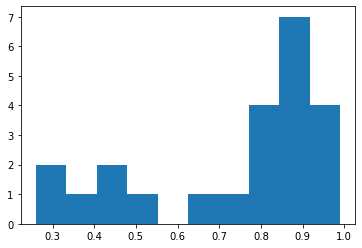

In [8]:
rs = []
for i in trange(len(plateifu_list)):
    r, points = ptp_down(i)
    rs.append(r)

plt.hist(rs)

In [11]:
rs

[0.5095684803001876,
 0.8111141983884415,
 0.43445632736679446,
 0.8788427819988313,
 0.651257777608123,
 0.7022448979591837,
 0.8112648221343874,
 0.34395161290322585,
 0.43583102065988283,
 0.2900840336134453,
 0.9070148188573106,
 0.9028906558889426,
 0.9901960784313727,
 0.860921883546318,
 0.9127530480791352,
 0.7817391304347826,
 0.8101725514341022,
 0.963045290358433,
 0.9350427350427349,
 0.9090713208360266,
 0.8958764901309361,
 0.932282508504944,
 0.259861080172536]

Text(0.5, 1.0, 'SFR to LOFAR flux correlation coefficients histogram')

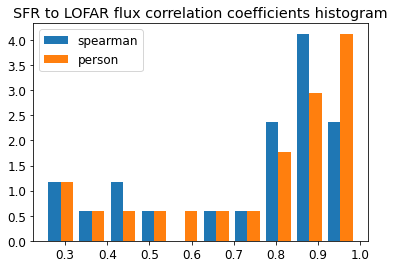

In [10]:
plt.rcParams['font.size'] = 12

fig = plt.gcf()
# fig.set_size_inches(10,10)
plt.hist([rs, rs_jelly],
         density=True,
         label=['spearman', 'person'])
plt.legend()
plt.title('SFR to LOFAR flux correlation coefficients histogram')